## Baseline Model

In [4]:
import json
import pandas as pd

games = pd.read_csv("games-full.csv", dtype={'game_id': str})
player_stats = pd.read_csv("player_game_stats-full-fixed.csv", dtype={'game_id': str})

# Only train on games from the regular season
games = games[games["game_id"].str.startswith("002")]
player_stats = player_stats[player_stats["game_id"].str.startswith("002")]

games_melted = games.melt(id_vars=["game_id", "season_year"], 
                          value_vars=["home_team_id", "away_team_id"],
                          value_name="team_id")

# Count unique game_id per team per season
games_played = games_melted.groupby(["season_year", "team_id"])["game_id"].nunique().reset_index()
games_played.rename(columns={"game_id": "games_played"}, inplace=True)

player_stats['player_game_stats'] = player_stats['player_game_stats'].apply(json.loads)

# Drop the original dictionary column
player_stats = player_stats.dropna(subset=['player_game_stats']).copy()

# Flatten the dictionary into separate columns
player_stats = pd.concat(
    [player_stats.drop(columns=['player_game_stats']), 
     player_stats['player_game_stats'].apply(pd.Series)], 
    axis=1
)

# Add the season_year to the player_stats dataframe
player_stats = player_stats.merge(games[['game_id', 'season_year']], on='game_id')

# Select only the required columns
stats_columns = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 
                 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 
                 'TO', 'PF', 'PTS']
player_stats = player_stats[['season_year', 'game_id', 'team_id'] + stats_columns]

# Aggregate player stats to get total game stats for each team
team_stats = player_stats.groupby(['game_id', 'team_id'])[stats_columns].sum().reset_index()

# Merge with games to determine home/away teams
team_stats = team_stats.merge(
    games[['game_id', 'season_year', 'home_team_id', 'away_team_id']], 
    on='game_id', 
    how='left'
)

# Merge home team stats
home_stats = team_stats[team_stats['team_id'] == team_stats['home_team_id']]
away_stats = team_stats[team_stats['team_id'] == team_stats['away_team_id']]

# Rename columns for clarity
home_stats = home_stats.rename(columns={col: col + "_home" for col in stats_columns}).drop(columns=['team_id'])
away_stats = away_stats.rename(columns={col: col + "_away" for col in stats_columns}).drop(columns=['team_id'])

# Merge home and away stats into one row per game
game_stats = home_stats.merge(away_stats, on=['game_id', 'season_year', 'home_team_id', 'away_team_id'], how='inner')

# Determine winner
game_stats["home_team_win"] = game_stats.apply(
    lambda row: 1 if row["PTS_home"] > row["PTS_away"] else 0, axis=1
)

# Now that the winner column has been added, we can split the home and away stats for more data transorformation
home_team_stats = game_stats[["game_id", "season_year", "home_team_id"] + [col for col in game_stats.columns if col.endswith("_home")]].copy()
away_team_stats = game_stats[["game_id", "season_year", "away_team_id"] + [col for col in game_stats.columns if col.endswith("_away")]].copy()

home_team_stats.columns = ["game_id", "season_year", "team_id"] + [col.replace("_home", "") for col in home_team_stats.columns[3:]]
away_team_stats.columns = ["game_id", "season_year", "team_id"] + [col.replace("_away", "") for col in away_team_stats.columns[3:]]

# Sort values by team
long_stats = pd.concat([home_team_stats, away_team_stats], axis=0).sort_values(["team_id", "season_year", "game_id"])

# Compute rolling average stats excluding current game
def compute_rolling_averages(group):
    return group[stats_columns].shift().expanding().mean()

long_stats_avg = long_stats.copy()
long_stats_avg[stats_columns] = long_stats.groupby(["team_id", "season_year"], group_keys=False).apply(compute_rolling_averages)

# Fill NaNs values (first game of season) using previous season's average stats
prev_season_averages = (
    long_stats
    .groupby(["team_id", "season_year"])[stats_columns]
    .mean()
    .reset_index()
)

# Shift season_year forward to align previous stats with the current season
def shift_season(season_str):
    start, end = season_str.split("-")
    next_start = str(int(start) + 1)
    next_end = str(int(end) + 1) if len(end) == 2 else str(int(end[-2:]) + 1).zfill(2)
    return f"{next_start}-{next_end}"

prev_season_averages["season_year"] = prev_season_averages["season_year"].apply(shift_season)

# Merge as fallback only where rolling average is missing (i.e., first game of season)
long_stats_avg = long_stats_avg.merge(
    prev_season_averages,
    on=["team_id", "season_year"],
    how="left",
    suffixes=("", "_fallback")
)

# Replace only NaNs (first game of season) with previous season average
for stat in stats_columns:
    long_stats_avg[stat] = long_stats_avg[stat].fillna(long_stats_avg[f"{stat}_fallback"])
    long_stats_avg.drop(columns=[f"{stat}_fallback"], inplace=True)

# Drop remaining NaNs (the first game of the 2018-19 season) and reset index
long_stats_avg.dropna(inplace=True)
long_stats_avg.reset_index(drop=True, inplace=True)

# Separate long_stats_avg into home and away based on game_id and team_id
home_features = long_stats_avg.merge(
    game_stats[['game_id', 'home_team_id']], 
    left_on=['game_id', 'team_id'], 
    right_on=['game_id', 'home_team_id'], 
    how='inner'
).drop(columns=['home_team_id'])

away_features = long_stats_avg.merge(
    game_stats[['game_id', 'away_team_id']], 
    left_on=['game_id', 'team_id'], 
    right_on=['game_id', 'away_team_id'], 
    how='inner'
).drop(columns=['away_team_id'])

# Rename columns to distinguish home and away
home_features = home_features.rename(columns={stat: f"{stat}_home" for stat in stats_columns})
away_features = away_features.rename(columns={stat: f"{stat}_away" for stat in stats_columns})

# Merge into a single row per game
ml_df = home_features.merge(
    away_features,
    on="game_id",
    suffixes=("_home", "_away")
)

# Merge with the target variable
ml_df = ml_df.merge(
    game_stats[["game_id", "home_team_win"]],
    on="game_id",
    how="inner"
)

# Drop unnecessary columns
ml_df = ml_df.drop(columns=["team_id_home", "team_id_away", "season_year_home", "season_year_away"])

# Final ML features and target
X = ml_df.drop(columns=["game_id", "home_team_win"])
y = ml_df["home_team_win"]

C:\Users\trito\AppData\Local\Temp\ipykernel_20592\3406241389.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_stats_avg[stats_columns] = long_stats.groupby(["team_id", "season_year"], group_keys=False).apply(compute_rolling_averages)


Accuracy: 0.6265
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.42      0.50       708
           1       0.64      0.78      0.70       920

    accuracy                           0.63      1628
   macro avg       0.62      0.60      0.60      1628
weighted avg       0.62      0.63      0.61      1628



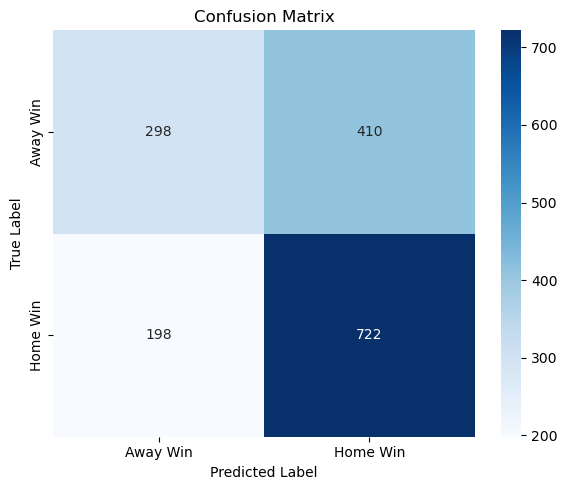

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy, 4))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels = ["Away Win", "Home Win"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()